# Abortion Access and Demand in the US
Candidate numbers: 42903, 50840

\* Note: many of the figures below are produced using plotly and therefore do not render on the remote Github repository automatically. Please run the code locally to see all figures.

## Introduction & Data Description
In June 2022, the US Supreme Court ruled on Dobbs v. Jackson Womens Health to overturn Roe v. Wade and return the decisionmaking on the legal status of abortion to the states. Many states had immediate trigger bans which went into effect immediately to restrict abortion access. Other states, expecting increasing demand from neighboring states with new bans, have started preparations to provide an increase in their abortion and family planning services. Given the recency of these policy changes it is difficult to determine how abortion demand and access has already changed since the Dobbs decision. However, it is simultaneously crucial to identify gaps in access and funding which will be exacerbated with the Dobbs decision.

Because of the political importance of abortion access, there are multiple public resources which gather data on abortion across the US. The Guttmacher Institute is a research agency which provides data about sexual and reproductive health and rights globally, and it is an important collector of longitudinal abortion services data by state across the US. The Kaiser Family Foundation focuses on health policy journalism within the US, and they also provide critical information on current state policies that relate to abortion access.

This project gathers data from the Guttmacher Institute and the Kaiser Family Foundation to look at historical trends in abortion demand by state as well as the political, health systems, and geographic determinants of access. Our goal is to identify the areas of greatest need for private funding for abortion based on the locations where abortion is banned outright as well as the states where public and private funding for abortion is limited.

## Research Questions
Given the changes to state policy after the 2022 Dobbs decision and the data available on historic abortion demand and utilization, we seek to answer the following questions:
1. Where is abortion access most restricted after Dobbs?
2. Where is demand the highest for abortion services?
3. Where should our attention and funding go?

## Data Processing and EDA
For simplicity and cleanness, the code which was used to extract and compile data from the Guttmacher Institute and the Kaiser Family Foundation is provided in the notebook titled `Data Extraction.ipynb`. Most data used in this analysis was already normalized and relatively clean, although some issues of data standardization and missingness persisted. 

<p>Data from the Kaiser Family Foundation - including insurance coverage for abortion, current policies across states -  is collected by researchers on their team. Data from the Guttmacher Institute - including abortion access, prevalence, and policies - is pulled from surveys and analysis on abortion and reproductive health. Data on historic abortion trends is pulled from the Center for Open Society Foundations (OSF), involving estimations and estimates from data collected by the Guttmacher Institute. Data on the US population is collected from the US Census Bureau (unmet needs.ipynb). Data is collected from a range of years (1988-2022).

In [1]:
import geopandas as gpd
import itertools
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import math
import graphviz
import plotly.offline as pyo
from graphviz import Digraph
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from collections import OrderedDict

pyo.init_notebook_mode(connected=True)

# Read time series data
abortion_trends = pd.read_csv("data/abortions_over_time_us.csv")

populations = abortion_trends.loc[abortion_trends['age'] == 'total'].copy()
populations['population'] = 1000*populations['abortions']/populations['abortionrate']
populations['population'] = populations['population'].astype(int)

abortion_trends = abortion_trends.merge(populations[["state","year","population"]], on=["state","year"])
abortion_trends["abortions"] = 1000*abortion_trends["abortions"]/abortion_trends["population"]

# Create a separate age-specific df for visualization
abortion_trends_by_age = abortion_trends[(~abortion_trends.age.isin(['1517','1819','lt20','total'])) &
                         (abortion_trends.year == 2017) & (abortion_trends.state != "US")].copy()

# Read abortion metrics and states policy data, and merge
metrics = pd.read_csv("data/abortion_access_data.csv")
state_policies = pd.read_csv("data/current_state_policies.csv")

state_policies['public_employee'] = state_policies['public_employee'].str.replace('"]',"", regex = True)
state_policies['restrictiveness'] = 'Most Restrictive'
state_policies.loc[state_policies['policy'] == 'Abortion legal beyond 22 weeks LMP',
                   "restrictiveness"] = 'Least Restrictive'
state_policies.loc[state_policies['policy'] == 'Gestational limit between 15 and 22 weeks LMP', 
                   'restrictiveness'] = 'Somewhat Restrictive'

metrics['Other insurance'] = 100 - (metrics['% of women aged 15-44 covered by Medicaid, 2017'] + 
                                             metrics['% of women aged 15-44 covered by private insurance, 2017'] + 
                                             metrics['% of women aged 15-44 who are uninsured, 2017'])
metrics.rename(columns = {'% of women aged 15-44 covered by Medicaid, 2017':'Medicaid',
                         '% of women aged 15-44 covered by private insurance, 2017':'Private',
                         '% of women aged 15-44 who are uninsured, 2017':'Uninsured',
                         'state_id':'state'}, inplace = True)
metrics = metrics.merge(state_policies, on = 'state')
metrics.head()

,state,"% change in abortion rate, 2017-2020",Medicaid,Private,Uninsured,"No. of abortions per 1,000 women aged 15–44, by state of occurrence, 2020","No. of abortions per 1,000 women aged 15–44, by state of residence, 2020","No. of abortions, by state of occurrence, 2020","No. of abortions, by state of residence, 2020","No. of federally funded abortions, 2010","No. of state funded abortions, 2010","Total no. of publicly funded abortions , 2010",Other insurance,policy,notes,private_insurance,marketplace,public_employee,restrictiveness
0,AL,-6,18,63,14,6.0,9.5,5700,9060.0,9,0,9,5,Abortion banned,"State abortion ban went into effect June 24, 202",No,Yes,No,Most Restrictive
1,AK,0,24,49,15,8.6,9.2,1240,1320.0,0,835,835,12,Abortion legal beyond 22 weeks LMP,No state law protecting or banning abortion; T...,No,No,No,Least Restrictive
2,AZ,1,24,60,13,9.3,9.7,13320,13820.0,1,13,14,3,Gestational limit between 15 and 22 weeks LMP,Current gestational limit is 15 weeks LMP. Pre...,No,Yes,Yes,Somewhat Restrictive
3,AR,2,28,58,11,5.6,7.8,3250,4510.0,0,0,0,3,Abortion banned,"Trigger law went into effect June 24, 2022, af...",No,Yes,No,Most Restrictive
4,CA,17,27,62,9,19.2,19.0,154060,152400.0,0,88466,88466,2,Abortion legal beyond 22 weeks LMP,State law protects the right to abortio,No,No,No,Least Restrictive


Although the data from all sources was already tabular and therefore relatively clean, some missingness persisted. Counts of missing data across data source are below.

In [2]:
missing_data_across_us = abortion_trends.isnull()
missing_data__across_us_count = missing_data_across_us.sum()
print(missing_data__across_us_count)

state             0
year              0
age               0
abortionrate    211
abortions       211
population        0
dtype: int64


In [3]:
state_pol = pd.read_csv("data/current_state_policies.csv")
missing_values = state_pol.isna().sum()
print(missing_values)

state                0
policy               0
notes                0
private_insurance    0
marketplace          0
public_employee      0
dtype: int64


In [4]:
abortion_access = pd.read_csv("data/abortion_access_data.csv", na_values='u')
missing_values = abortion_access.isna().sum()
print(missing_values)

state_id                                                                     0
% change in abortion rate, 2017-2020                                         0
% of women aged 15-44 covered by Medicaid, 2017                              0
% of women aged 15-44 covered by private insurance, 2017                     0
% of women aged 15-44 who are uninsured, 2017                                0
No. of abortions per 1,000 women aged 15–44, by state of occurrence, 2020    0
No. of abortions per 1,000 women aged 15–44, by state of residence, 2020     1
No. of abortions, by state of occurrence, 2020                               0
No. of abortions, by state of residence, 2020                                1
No. of federally funded abortions, 2010                                      0
No. of state funded abortions, 2010                                          9
Total no. of publicly funded abortions , 2010                                6
dtype: int64


In [5]:
census_data = pd.read_csv("data/census_updated.csv")
missing_values = census_data.isna().sum()
print(missing_values)

state         0
population    0
dtype: int64


Based on missing data analysis on our intial csv files, the current_state_policies and census data appear to have no missing values. Meanwhile, there appears to be some missing data for abortion_access_data and abortions_over_us. For our analysis, missing values are filtered and replaced accordingly. Abortion policies are statified into three groups: most restrictive, somewhat restrictive, and least restrictive.

## Analysis
### Where is abortion access most restricted?
The Dobbs decision led many states to enact immediate bans on abortion which were already written into state law and triggered by the Supreme Court ruling. The Kaiser Family Foundation keeps track of current state policies, which is shown in the map below.

In [6]:
ban_states_map = px.choropleth(metrics,
                    locations= 'state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='policy',
                    custom_data = ['policy'],
                    category_orders={'policy':['Abortion banned','6 week LMP gestational limit in effect',
                                              'Gestational limit between 15 and 22 weeks LMP',
                                               'Abortion legal beyond 22 weeks LMP']},
                    color_discrete_sequence=['#9f2a63','#d44842','#f57d15','#fac228'],
                    title = "Current State Abortion Policies",
                              height = 400)
ban_states_map.update_layout(dragmode=False, legend_title = "")
ban_states_map.update_traces(hovertemplate = '''<b>%{location}</b> <br> %{customdata[0]} <extra></extra>''')
ban_states_map.show()

From this map it's apparent that the majority of states that have kept abortion legal beyond 22 weeks are along the west coast and central west of the US, as well as the states in the northeast. The states that have banned abortion outright are clustered in the deep south and the rust belt, along with a few outliers of Idaho, South Dakota and Wisconsin. 

Many states constrain the length of time that an abortion is legal, including Florida and Ohio. Legally, most states determine these bans based on the time since the last menstrual period (LMP). However, a 
[2012 CDC report](https://www.cdc.gov/mmwr/preview/mmwrhtml/ss6410a1.htm)
finds that less than 5% abortions were performed after 13 weeks gestation, so prohibitions beyond 15 or even 22 weeks have a minor effect on the total demand for abortion in any state.

Even when abortion is legal it is not always accessible. At [Planned Parenthood](https://www.plannedparenthood.org/learn/ask-experts/how-much-does-an-abortion-cost), an abortion typically costs \\$600 during the first trimester of pregnancy but that cost can go up to \\$2000 in the second trimester. Some states restrict which types of insurance can cover abortion or have high rates of uninsured women, and for these populations cost may be a prohibitive barrier to seeking care. 


The pie charts pictured below investigate insurance coverage for abortions, measuring the percent of states that offer abortion coverage for three common types of insurance: private, marketplace, and public employee. Across all three insurance types, there is a high proportion of states that do not offer abortion coverage (over 40% for each). The charts suggest that marketplace insurance tends to have the highest coverage for abortion across states, whereas private insurance tends to have the lowest proportion of coverage for abortion across states.



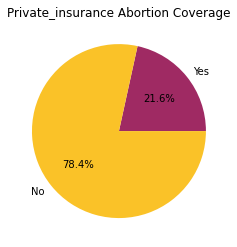

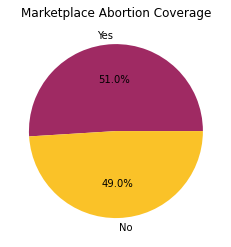

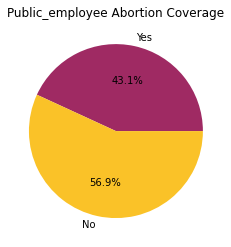

In [7]:
# Pie charts of insurance coverage
insurance_types = ['private_insurance', 'marketplace', 'public_employee']

for insurance_type in insurance_types:
    insurance_type_df = state_policies[['state', insurance_type]]
    cover_yes = len(insurance_type_df[insurance_type_df[insurance_type] == 'Yes'])
    cover_no = len(insurance_type_df[insurance_type_df[insurance_type] == 'No'])
    proportions = [cover_yes, cover_no]
    fig, ax = plt.subplots()
    ax.pie(proportions, labels=['Yes', 'No'], autopct='%1.1f%%', colors=['#9f2a63', '#fac228'])
    ax.set_title(f'{insurance_type.capitalize()} Abortion Coverage')
    plt.show()

Additionally, we looked at the insurance coverage in legal states and contrasted this with the insurance policies described above. Maps of the proportion of women without insurance, with private insurance that covers abortion, and on Medicaid which covers abortion are shown below. The data for these maps is from the Guttmacher Institute, with insurance coverage rates from 2017.

In [8]:
legal_states = metrics.loc[metrics.policy != "Abortion banned"]['state']
uninsured_map = px.choropleth(metrics.loc[metrics.state.isin(legal_states)],
                    locations= 'state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Uninsured',
                    custom_data = ['Uninsured'],
                    color_continuous_scale="inferno",
                    title = "Percent of Women aged 15-44 Without Insurance",
                             height = 400)
uninsured_map.update_layout(dragmode=False, legend_title = "")
uninsured_map.update_traces(hovertemplate = '''<b>%{location}</b> <br> %{customdata[0]}% uninsured <extra></extra>''')
uninsured_map.show()

In [10]:
private_states = metrics.loc[(metrics.policy != "Abortion banned") &
                             (metrics.private_insurance == "No")]['state']
private_map = px.choropleth(metrics.loc[metrics.state.isin(private_states)],
                    locations= 'state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Private',
                    custom_data = ['Private'],
                    color_continuous_scale="inferno_r",
                    title = "Private insurance coverage for abortion",
                           height = 400)
private_map.update_layout(dragmode=False, legend_title = "")
private_map.update_traces(hovertemplate = '''<b>%{location}</b> <br> %{customdata[0]}% on private 
insurance <extra></extra>''')
private_map.show()

In [11]:
medicaid_states = metrics.loc[(metrics.policy != "Abortion banned") &
                             (metrics['Total no. of publicly funded abortions , 2010'] != 0)]['state']
medicaid_map = px.choropleth(metrics.loc[metrics.state.isin(medicaid_states)],
                    locations= 'state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Medicaid',
                    custom_data = ['Medicaid'],
                    color_continuous_scale="inferno_r",
                    title = "Medicaid coverage for abortion",
                            height = 400)
medicaid_map.update_layout(dragmode=False, legend_title = "")
medicaid_map.update_traces(hovertemplate = '''<b>%{location}</b> <br> %{customdata[0]}%
on Medicaid <extra></extra>''')
medicaid_map.show()

The ways that women are covered clearly varies substantially by state. As another way to visualize this variation, a bar plot below shows the distribution of insurance coverage for women aged 15-44 in each state.

<p>The majority of women tend to be privately insured across all states. States in the southern U.S. (i.e. Texas, Oklahoma, Georgia) appear to have a higher proportion of women uninsured.

In [12]:
metrics.sort_values(by="Uninsured", inplace=True)
fig = px.bar(metrics, 
             x = 'state', 
             height = 400,
             y = ['Uninsured','Private','Medicaid','Other insurance'],
             color_discrete_sequence = ['#fac228','#65156e','#9f2a63','#d44842'])
fig.update_layout(bargap = 0, title = "Insurance Coverage by State", xaxis_title = "", 
                 yaxis_title = "", legend_title = "", xaxis = {'tickmode':'linear'})
fig.update_xaxes(matches=None, showticklabels=True, tickangle = 270)
fig.update_yaxes(range = [0,100], ticksuffix = "%")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(width=1, hovertemplate = None)
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.03, xanchor="right", x=1), 
                  hovermode="x unified")
fig.show()

### Where is demand the highest for abortion services?
#### Forecasting abortion demand to 2023
The Guttmacher Institute publishes time series information on abortion services by state and age group dating back to 1988. However, this time series only extends to 2017. Additional data sources report abortions for the year 2020, but the source of this information is not consistent with Guttmacher's time series and the Covid-19 pandemic impacted abortion demand in many ways, including the number of pregnancies occuring and womens' ability to travel for abortion services. 
<p>We were interested in predicting the total demand for abortion services in 2023 after the Dobbs decision. In order to do so, we decided to forecast the trends from 2017 forward to recent years. We expect these trends to be an inaccurate representation of true demand after the pandemic and the Dobbs decision. However, we believe that these forecasts will be more comprehensive of hypothetical demand if Roe was not overturned, and will not be unduly biased by the shock of the 2020-2021 pandemic shutdown years.
<p>To forecast abortion demand, we used an autoregressive integrated moving average (ARIMA) model. This type of model is commonly used for time series forecasts, and it uses a local moving average of prior years to forecast trends in subsequent years. We modeled in log-space to constrain the abortion rate between zero and 1, and only used the years from 2005 onwards because this is when Guttmacher provides single-year updates. Data processing for this modeling is shown below.

In [13]:
abortion_trends["log_arate"] = np.log(abortion_trends["abortionrate"]/1000)
abortion_trends = abortion_trends.loc[(abortion_trends.age == "total") & (abortion_trends.year >= 2005)]
abortion_trends['year'] = pd.to_datetime(abortion_trends['year'], format='%Y')
abortion_trends.sort_values(by=['state','year'], inplace = True)
abortion_trends['source'] = "Data"
abortion_trends['abortionrate_lower'] = abortion_trends['abortionrate']
abortion_trends['abortionrate_upper'] = abortion_trends['abortionrate']
abortion_trends.head()

,state,year,age,abortionrate,abortions,population,log_arate,source,abortionrate_lower,abortionrate_upper
54,AK,2005-01-01,total,15.0,15.000000,142000,-4.199705,Data,15.0,15.0
65,AK,2006-01-01,total,14.5,14.500099,142068,-4.233607,Data,14.5,14.5
76,AK,2007-01-01,total,14.1,14.100097,141843,-4.261580,Data,14.1,14.1
87,AK,2008-01-01,total,13.9,13.900019,141007,-4.275866,Data,13.9,13.9
98,AK,2009-01-01,total,14.3,14.300034,142657,-4.247496,Data,14.3,14.3


The ARIMA modeling for New York is shown below as an example. We used AIC to compare multiple model specifications for three hyperparameters:
1. The auto-regressive dimension of the model. This determines how far we are looking back to determine the new prediction.
2. The level of integration in the model. This reflects how much of the stochasticity or smoothness from previous points in time should be carried into the predictions.
3. The moving average component of the model, which determines how the error of the forecast is determined as a function of prior points' error.

<p>Although only one example state is shown, the lowest AIC across most states was a (1,1,0) specification for the parameters listed above. Below the AIC output we display summary plots of the New York model fit.

In [14]:
# ARIMA state example
abortion_trends_NY = abortion_trends.loc[(abortion_trends.state == "NY")].copy()
abortion_trends_NY.sort_values(by='year', inplace = True)
abortion_trends_NY.set_index('year', inplace = True)
abortion_trends_NY.index = pd.DatetimeIndex(abortion_trends_NY.index.values,
                               freq=abortion_trends_NY.index.inferred_freq)

warnings.filterwarnings("ignore") # specify to ignore warning messages
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

for param in pdq:
    try:
        mod = ARIMA(abortion_trends_NY['log_arate'],order=param)
        res = mod.fit()
        print('ARIMA{} - AIC:{}'.format(param, res.aic))
    except:
        continue

ARIMA(0, 0, 0) - AIC:-14.870401329944421
ARIMA(0, 0, 1) - AIC:-24.809962229329376
ARIMA(0, 0, 2) - AIC:-31.71679781590636
ARIMA(0, 1, 0) - AIC:-41.16667754159765
ARIMA(0, 1, 1) - AIC:-42.16468443988618
ARIMA(0, 1, 2) - AIC:-40.22923742598053
ARIMA(0, 2, 0) - AIC:-37.740197039048304
ARIMA(0, 2, 1) - AIC:-39.921890827451605
ARIMA(0, 2, 2) - AIC:-38.25003202188323
ARIMA(1, 0, 0) - AIC:-38.138731888878205
ARIMA(1, 0, 1) - AIC:-39.230530585011174
ARIMA(1, 0, 2) - AIC:-37.31700831782374
ARIMA(1, 1, 0) - AIC:-42.668431082188704
ARIMA(1, 1, 1) - AIC:-42.2635965061237
ARIMA(1, 1, 2) - AIC:-40.52770214514822
ARIMA(1, 2, 0) - AIC:-37.110665469517556
ARIMA(1, 2, 1) - AIC:-38.135379325276524
ARIMA(1, 2, 2) - AIC:-36.47899823371725
ARIMA(2, 0, 0) - AIC:-39.82838465754334
ARIMA(2, 0, 1) - AIC:-41.86547540261773
ARIMA(2, 0, 2) - AIC:-36.90706925508337
ARIMA(2, 1, 0) - AIC:-40.87218960874581
ARIMA(2, 1, 1) - AIC:-40.41402667105273
ARIMA(2, 1, 2) - AIC:-38.31326548972176
ARIMA(2, 2, 0) - AIC:-38.4702678

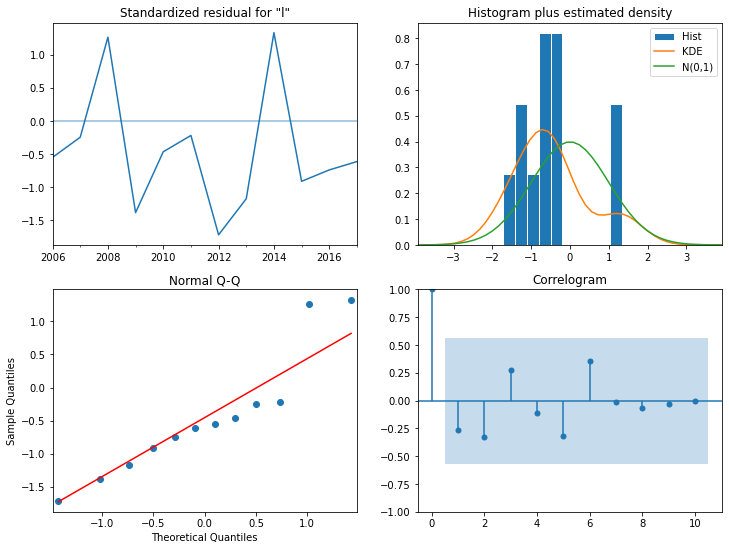

In [15]:
best_fit_NY = ARIMA(abortion_trends_NY['log_arate'], order = (1,1,0))
best_fit_NY = best_fit_NY.fit()
best_fit_NY.plot_diagnostics(figsize=(12, 9))
plt.show()

Clearly from these plots, the data is not perfectly normal. However, this likely relates to the small sample of time series data, and to the fact that data is reported anually instead of quarterly or monthly. Models for all states are run below, and summary statistics on the predicted 2023 abortion rates are displayed.

In [16]:
extended_trends = pd.DataFrame()
warnings.filterwarnings("ignore") # specify to ignore warning messages

for state in abortion_trends.state.unique():
    single_state_trends = abortion_trends.loc[abortion_trends.state == state]
    single_state_trends.set_index('year', inplace = True)
    single_state_trends.index = pd.DatetimeIndex(single_state_trends.index.values,
                               freq=single_state_trends.index.inferred_freq)
    
    results = ARIMA(single_state_trends['log_arate'], order = (1,1,0))
    results = results.fit()
    extrapolation = results.get_forecast(steps = 6)
    extrapolation_ci = extrapolation.conf_int()
    df = pd.concat([extrapolation.predicted_mean, extrapolation_ci], axis = 1)
    df['state'] = state
    extended_trends = pd.concat([extended_trends,df], axis = 0)
    
extended_trends[['predicted_mean',
                 'lower log_arate',
                 'upper log_arate']] = extended_trends[['predicted_mean',
                                                        'lower log_arate',
                                                        'upper log_arate']].apply(lambda x: np.exp(x)*1000)
extended_trends = extended_trends.round(2)
extended_trends.reset_index(names = 'year', inplace = True)
extended_trends.rename(columns = {'predicted_mean':'abortionrate','lower log_arate':'abortionrate_lower',
                                 'upper log_arate':'abortionrate_upper'}, inplace = True)
extended_trends['age'] = 'total'
extended_trends['source'] = "Forecast"
abortion_trends = pd.concat([abortion_trends, extended_trends], axis = 0)
abortion_trends['year'] = abortion_trends['year'].dt.year.astype("int")
abortion_trends.sort_values(by=['state','year'], inplace = True)
abortion_trends.reset_index(inplace = True)
abortion_trends.drop(['log_arate','index'], inplace = True, axis = 1)

abortion_trends.loc[abortion_trends.year == 2023].abortionrate.describe()

count    52.000000
mean     11.047500
std       5.365559
min       4.330000
25%       7.452500
50%       9.540000
75%      13.250000
max      27.520000
Name: abortionrate, dtype: float64

The plots below show the time series trends where each grey line is a state's abortion rate over time. We've chosen a few states to highlight in purple, where the solid line is the Guttmacher data and the dotted line is the forecasted rate with a 95% confidence interval. States with more instability over time and smaller populations have higher uncertainty.

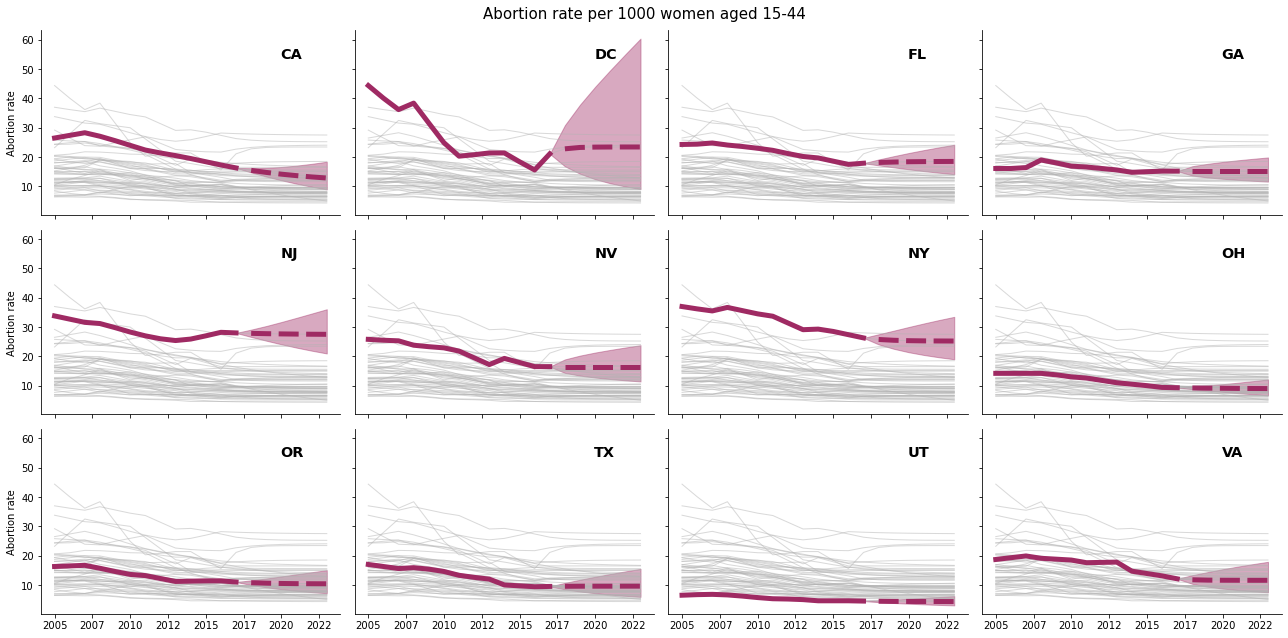

In [17]:
# Plot each state's time series in its own facet
states_of_interest = ['UT','FL','GA','OH','TX','NV','VA','CA','OR','DC','NY','NJ']

g = sns.relplot(
    data=abortion_trends.loc[abortion_trends['state'].isin(states_of_interest)],
    x="year", y="abortionrate", col="state", color = '#9f2a63', style = "source",
    kind="line", linewidth=5, zorder=5,
    col_wrap=4, height=3, aspect=1.5, legend=False,
)

# Iterate over each subplot to add uncertainty and background trends
for st, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, st, transform=ax.transAxes, fontweight="bold", fontsize = "x-large")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

    # Plot every year's time series in the background
    sns.lineplot(
        data=abortion_trends,
        x="year", y="abortionrate", units="state", alpha = 0.5,
        estimator=None, color=".7", linewidth=1, ax=ax,
    )
    
    # Add uncertainty
    ax.fill_between(abortion_trends.loc[abortion_trends['state'] == st].year,
                abortion_trends.loc[abortion_trends['state'] == st].abortionrate_upper,
                abortion_trends.loc[abortion_trends['state'] == st].abortionrate_lower, 
                    color='#9f2a63', alpha = 0.4)

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Abortion rate")
plt.suptitle("Abortion rate per 1000 women aged 15-44", fontsize = 15)
g.tight_layout()

#### Disaggregating demand by age
The age distribution of women seeking abortion is informative about how easy it is for women to travel out of state for abortion services or to pay out of pocket for care. The age pattern distribution from 2017 from the Guttmacher institute is shown below.

In [18]:
age_dict = {'lt15':'Under 15', '1519':'15 to 19', '2024':'20 to 24', '2529':'25 to 29', '3034':'30 to 34',
           '3539':'35 to 39', '40plus':'40 and older'}

abortion_trends_by_age['age_groups'] = abortion_trends_by_age['age'].map(age_dict)
fig = px.bar(abortion_trends_by_age, y="state", x="abortions", color="age_groups", 
             custom_data = ['age_groups','abortionrate'],
             title="Abortions per 1000 women aged 15-44, 2017", height = 800,
             color_discrete_sequence=['#000004','#280b53','#65156e','#9f2a63','#d44842',
                                      '#f57d15','#f98e09','#fac228'],
             category_orders={'age_groups':['Under 15','15 to 19','20 to 24', '25 to 29', 
                                           '30 to 34', '35 to 39', '40 plus']},
            labels = {'age_groups':'Age', 'state':'State', 'abortions':'Abortion rate per 100,000'})
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending','tickmode':'linear'}, legend_title="Age",
                 template = "plotly_white", bargap = 0)
fig.update_traces(hovertemplate = '''<b>%{y}</b> <br> Age: %{customdata[0]} <br> Abortions: 
%{customdata[1]:.2f} per 1000 <extra></extra>''')
fig.show()

#### Traveling for abortion services
Even before Dobbs, there was substantial interstate travel for women who were seeking abortion services. The plot below compares the number of abortions provided in each state versus the number of state residents who sought abortion care. States like Texas, Virginia and Missouri already had substantial demand out-of-state for abortions, and with Dobbs bans this will continue to increase. Conversely, states like Illinois, Colorado and Kansas may need additional support for clinics that provide abortions if out-of-state demand increases further with Dobbs.

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=metrics.state,
    x=metrics["No. of abortions, by state of occurrence, 2020"],
    mode = "markers",
    name = "Occurence",
    marker=dict(color="#65156e", size=8) 
))

fig.add_trace(go.Scatter(
    y=metrics.state,
    x=metrics["No. of abortions, by state of residence, 2020"],
    mode = "markers",
    name = "Residence",
    marker=dict(color="#fac228", size=8)))

fig.add_trace

fig.update_layout(title="State Demand and Capacity for Abortions, 2020",
                  xaxis_title="Number of abortions per 1000 women aged 15-44",
                  yaxis_title="State",
                 height = 800)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total descending','tickmode':'linear'},
                 template = "plotly_white", bargap = 0, hovermode = "y unified")
fig.show()

To further analyze the proximity of states with different legal requirements for abortion, a state adjacency matrix was developed. A heatmap of the adjacency matrix is displayed below. As shown, many states that restrict abortion coverage neighbor multiple other states. States with many neighbors will likely drive demand for abortion services in neighboring states up, as shown in the figure above. Further analysis on these neighbors and potential travel opportunities is conducted below.


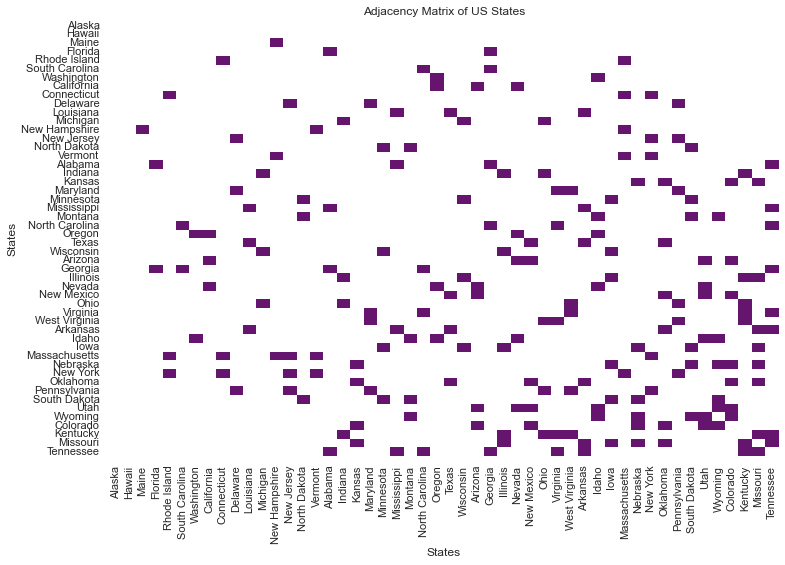

In [20]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
          'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 
          'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
          'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 
          'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
          'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
          'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

state_abbreviations = {'AL': 'Alabama','AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas','CA': 'California',
                       'CO': 'Colorado','CT': 'Connecticut','DC': 'Washington DC','DE': 'Delaware',
                       'FL': 'Florida','GA': 'Georgia','HI': 'Hawaii','ID': 'Idaho','IL': 'Illinois',
                       'IN': 'Indiana','IA': 'Iowa','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
                       'ME': 'Maine','MD': 'Maryland','MA': 'Massachusetts','MI': 'Michigan','MN': 'Minnesota',
                       'MS': 'Mississippi','MO': 'Missouri','MT': 'Montana','NE': 'Nebraska','NV': 'Nevada',
                       'NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NY': 'New York',
                       'NC': 'North Carolina','ND': 'North Dakota','OH': 'Ohio','OK': 'Oklahoma',
                       'OR': 'Oregon','PA': 'Pennsylvania','RI': 'Rhode Island','SC': 'South Carolina',
                       'SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas','UT': 'Utah','VT': 'Vermont',
                       'VA': 'Virginia','WA': 'Washington','WV': 'West Virginia','WI': 'Wisconsin',
                       'WY': 'Wyoming'
}

neighbors = {'Alabama': ['Florida', 'Georgia', 'Mississippi', 'Tennessee'], 'Alaska': [],
         'Arizona': ['California', 'Colorado', 'Nevada', 'New Mexico', 'Utah'],
         'Arkansas': ['Louisiana', 'Mississippi', 'Missouri', 'Oklahoma', 'Tennessee', 'Texas'],
         'California': ['Arizona', 'Nevada', 'Oregon'],
         'Colorado': ['Arizona', 'Kansas', 'Nebraska', 'New Mexico', 'Oklahoma', 'Utah', 'Wyoming'],
         'Connecticut': ['Massachusetts', 'New York', 'Rhode Island'],
        'Delaware': ['Maryland', 'New Jersey', 'Pennsylvania'],
        'Florida': ['Alabama', 'Georgia'],
        'Georgia': ['Alabama', 'Florida', 'North Carolina', 'South Carolina', 'Tennessee'],
        'Hawaii': [],
        'Idaho': ['Montana', 'Nevada', 'Oregon', 'Utah', 'Washington', 'Wyoming'],
        'Illinois': ['Indiana', 'Iowa', 'Kentucky', 'Missouri', 'Wisconsin'],
        'Indiana': ['Illinois', 'Kentucky', 'Michigan', 'Ohio'],
        'Iowa': ['Illinois', 'Minnesota', 'Missouri', 'Nebraska', 'South Dakota', 'Wisconsin'],
        'Kansas': ['Colorado', 'Missouri', 'Nebraska', 'Oklahoma'],
        'Kentucky': ['Illinois', 'Indiana', 'Missouri', 'Ohio', 'Tennessee', 'Virginia', 'West Virginia'],
        'Louisiana': ['Arkansas', 'Mississippi', 'Texas'],
        'Maine': ['New Hampshire'],
        'Maryland': ['Delaware', 'Pennsylvania', 'Virginia', 'West Virginia'],
        'Massachusetts': ['Connecticut', 'New Hampshire', 'New Jersey', 'New York', 'Rhode Island', 'Vermont'],
        'Michigan': ['Indiana', 'Ohio', 'Wisconsin'],
        'Minnesota': ['Iowa', 'North Dakota', 'South Dakota', 'Wisconsin'],
        'Mississippi': ['Alabama', 'Arkansas', 'Louisiana', 'Tennessee'],
        'Missouri': ['Arkansas', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Nebraska', 'Oklahoma', 'Tennessee'],
        'Montana': ['Idaho', 'North Dakota', 'South Dakota', 'Wyoming'],
        'Nebraska': ['Colorado', 'Iowa', 'Kansas', 'Missouri', 'South Dakota', 'Wyoming'],
        'Nevada': ['Arizona', 'California', 'Idaho', 'Oregon', 'Utah'],
        'New Hampshire': ['Maine', 'Massachusetts', 'Vermont'],
        'New Jersey': ['Delaware', 'New York', 'Pennsylvania'],
        'New Mexico': ['Arizona', 'Colorado', 'Oklahoma', 'Texas', 'Utah'],
        'New York': ['Connecticut', 'Massachusetts', 'New Jersey', 'Pennsylvania', 'Rhode Island', 'Vermont'],
        'North Carolina': ['Georgia', 'South Carolina', 'Tennessee', 'Virginia'],
        'North Dakota': ['Minnesota', 'Montana', 'South Dakota'],
        'Ohio': ['Indiana', 'Kentucky', 'Michigan', 'Pennsylvania', 'West Virginia'],
        'Oklahoma': ['Arkansas', 'Colorado', 'Kansas', 'Missouri', 'New Mexico', 'Texas'],
        'Oregon': ['California', 'Idaho', 'Nevada', 'Washington'],
        'Pennsylvania': ['Delaware', 'Maryland', 'New Jersey', 'New York', 'Ohio', 'West Virginia'],
        'Rhode Island': ['Connecticut', 'Massachusetts'],
        'South Carolina': ['Georgia', 'North Carolina'],
        'South Dakota': ['Iowa', 'Minnesota', 'Montana', 'Nebraska', 'North Dakota', 'Wyoming'],
        'Tennessee': ['Alabama', 'Arkansas', 'Georgia', 'Kentucky', 'Mississippi', 'Missouri', 
                      'North Carolina', 'Virginia'],
        'Texas': ['Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma'],
        'Utah': ['Arizona', 'Colorado', 'Idaho', 'Nevada', 'New Mexico', 'Wyoming'],
        'Vermont': ['Massachusetts', 'New Hampshire', 'New York'],
        'Virginia': ['Kentucky', 'Maryland', 'North Carolina', 'Tennessee', 'West Virginia'],
        'Washington': ['Idaho', 'Oregon'],
        'West Virginia': ['Kentucky', 'Maryland', 'Ohio', 'Pennsylvania', 'Virginia'],
        'Wisconsin': ['Illinois', 'Iowa', 'Michigan', 'Minnesota'],
        'Wyoming': ['Colorado', 'Idaho', 'Montana', 'Nebraska', 'South Dakota', 'Utah']
}

# Order the neighbors dict to sort the adjacency matrix by
ordered_neighbors = OrderedDict(sorted(neighbors.items(), key=lambda x: len(x[1])))
ordered_neighbors_list = list(ordered_neighbors.keys())

adj_matrix = np.zeros((50,50), dtype=int)
def is_neighbor(state1, state2):
    if state2 in ordered_neighbors[state1]:
        return 1
    else:
        return 0

for i in range(50):
    for j in range(50):
        adj_matrix[i, j] = is_neighbor(ordered_neighbors_list[i], ordered_neighbors_list[j])
        
sns.set(rc={"figure.figsize":(12, 8)})
sns.heatmap(adj_matrix, cmap=["white","#65156e"], cbar = False, xticklabels = ordered_neighbors_list, 
            yticklabels = ordered_neighbors_list)
plt.xlabel('States')
plt.ylabel('States')
plt.title('Adjacency Matrix of US States')
plt.show()

As shown in the table below, the only state with outright bans on abortion which has no neighboring states that allow for abortion services is Alabama. However, this neighboring state analysis doesn't reflect the within-state driving distance or costs for women traveling, and as more states implement bans on abortion care the status of states with legal neighbors could change.

In [21]:
df = state_policies.copy()
df["legal"] = 1
df.loc[df.policy == "Abortion banned","legal"] = 0

banned_states = df[df["legal"] == 0]
legal_states = df[df["legal"] == 1]
banned_states_list = list(banned_states["state"])
legal_states_list = list(legal_states["state"])
banned = [state_abbreviations[state] for state in banned_states_list]
legal = [state_abbreviations[state] for state in legal_states_list]

#iterating through list of banned states - looking at adjacency matrix if there is any overlap
banned_states = []
for banned_state in banned:
    banned_index = states.index(banned_state)
    neighboring_states = [states[i] for i in range(len(states)) if adj_matrix[banned_index, i] == 1]
    has_legal_neighbor = any(state in legal for state in neighboring_states)
    banned_states.append({"banned_state": banned_state, "has_legal_neighbor": int(has_legal_neighbor)})
    
pd.DataFrame(banned_states)

,banned_state,has_legal_neighbor
0,Alabama,0
1,Arkansas,1
2,Idaho,1
3,Kentucky,1
4,Louisiana,1
5,Mississippi,1
6,Missouri,1
7,Oklahoma,1
8,South Dakota,1
9,Tennessee,1


In [22]:
#Sankey Diagram
dt = pd.DataFrame.from_dict(ordered_neighbors, orient='index')
dt.reset_index(inplace = True)
dt.columns = ["state","n1","n2","n3","n4","n5","n6","n7","n8"]
dt = pd.wide_to_long(dt, "n", i = "state", j = "neighbors")
dt.reset_index(inplace = True)
dt["value"] = 1
dt = dt[~(dt.n.isnull())]

dt["state_idx"] = list(map(states.index, dt['state']))
dt["n_idx"] = list(map(states.index, dt['n']))

dt = dt[dt.state.isin(banned) & dt.n.isin(legal)]

data = py.graph_objs.Sankey(
    node = dict(
        pad = 20,
        thickness = 1,
        line = dict(
            color = 'black',
            width = 0.5
        ),
        label = states,
        color = "#fac228"
    ),
    link = dict(
        source = dt.state_idx,
        target = dt.n_idx,
        value = dt.value,
        color = ['#fac228']*sum(sum(adj_matrix)),
    ),
    orientation = "h",
    arrangement = "fixed",
    textfont=dict(size=14)
)

layout = py.graph_objs.Layout(
    title = "Legal States Connected to Banned States",
    font=dict(size=14),
    height = 700,
)

fig = py.graph_objs.Figure(data=[data], layout=layout)
fig.show()

While many banned states appear to neighbor states for which abortion is legal, the number of neighboring states varies. Texas and Alabama appear to have fewer connections to legal states, whereas Idaho and South Dakota have more connections to legal states. Given there are limited adjacent legal states for Texas and Alabama, there might be a higher demand for out-of-state abortions in the states that neighbor them: Florida, Georgia, and New Mexico. Meanwhile, legal states such as Illinois and Iowa seem to have a high number of states for which abortion is restricted. Therefore, demand for out-of-state abortions might be high in these states as well.

### Where should we direct funding and attention?
An Unmet Needs Model was developed to explore gaps in abortion access and opportunities for funding. Two submodels were developed: one for the unmet needs for women residing in banned states, and one for unmet needs for women residing in states where abortion is legal. The total number of women with unmet abortion needs was calculated for each submodel.

#### Unmet Need Model: For Banned States
Per the [US Census Bureau](https://www.census.gov/quickfacts/fact/table/US/PST045222), 50.2% of the 2023 population is female and 39.0% of the national female population is aged 15-44. These numbers are used in calculations of the total abortion demand below to estimate the total population of women of childbearing age in each state.

In [23]:
census = pd.read_csv('data/census_updated.csv')
census = census[['state', 'population']]

census['percent_women'] = 0.502 # 2023 percent of national population that's female
census['age_15_44'] = 0.390 # 2023 percent of national female population that's age 15-44
census = census[census.state.isin(banned_states_list)]
census = pd.merge(census, abortion_trends.loc[abortion_trends.year == 2023][['state','abortionrate']].copy(), 
                  on='state')

census['total population of women age 15-44'] = census['population']*census['percent_women']* \
    census['age_15_44']
census['total abortions by state of residence'] = census['total population of women age 15-44']* \
    census['abortionrate']/1000
census.head()

,state,population,percent_women,age_15_44,abortionrate,total population of women age 15-44,total abortions by state of residence
0,AL,5074296.0,0.502,0.39,7.78,993445.67088,7729.007319
1,AR,3045637.0,0.502,0.39,6.84,596274.81186,4078.519713
2,ID,1939033.0,0.502,0.39,5.29,379623.88074,2008.210329
3,KY,4512310.0,0.502,0.39,5.68,883420.05180,5017.825894
4,LA,4590241.0,0.502,0.39,8.99,898677.38298,8079.109673


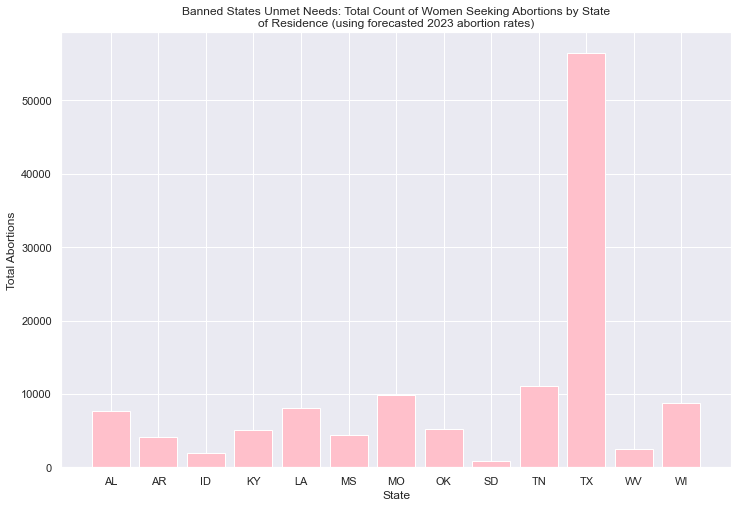

In [24]:
plt.bar(census['state'], census['total abortions by state of residence'], color='pink')
plt.title('''Banned States Unmet Needs: Total Count of Women Seeking Abortions by State
of Residence (using forecasted 2023 abortion rates)''')
plt.xlabel('State')
plt.ylabel('Total Abortions')
plt.show()

In [25]:
sum_population = census['population'].sum()
sum_women_of_childbearing_age = census['total population of women age 15-44'].sum()
sum_total_seeking_abortions = census['total abortions by state of residence'].sum()

data = [
    ('Total Population Residing in States Where Abortion has been Banned', sum_population),
    ('Number of Women age 15-40', sum_women_of_childbearing_age),
    ('Total Count of Women Residing in Banned States who are Seeking Abortions', sum_total_seeking_abortions)
]

colors = ['#FF3C3C','#FF6B6B', '#FFC5C5']

fig = go.Figure(go.Funnel(
    y=[item[0] for item in data],
    x=[item[1] for item in data],
    marker={'color': colors}
))

fig.update_layout(
    title='Banned States: Unmet Needs Funnel Diagram',
    funnelmode='overlay',
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14)
)

fig.show()

To calculate the count of women residing in banned states who are seeking abortions, we multiplied the number of women of childbearing age by the forecasted abortion rate for each state. The number of women of childbearing age was calculated by multiplying the total population of residents in that state by the percent of population who are female and the percent of female population who are of childbearing age (data from US Census Bureau). Information was pulled from corresponding .csv files scraped from Guttmacher Institute, KFF, and the 2023 abortion rate forecasts predicted. The total counts by each banned state are displayed in the bar chart above.

As shown in the final funnel output, the total count of women residing in banned states who are seeking abortions comes out to be approximately 12.6k. The state that appears to have the highest count of women seeking abortions is Texas.

#### Unmet Need Model: For Legal States

In [26]:
metrics['Total no. of publicly funded abortions , 2010'].fillna(0, inplace = True)
metrics['Total no. of publicly funded abortions , 2010'].replace('u', 0, regex = True, inplace = True)
metrics['Total no. of publicly funded abortions , 2010'] = \
    pd.to_numeric(metrics['Total no. of publicly funded abortions , 2010'])

metrics['Total no. of publicly funded abortions , 2010'].dtype
metrics = metrics.rename(columns={'state_id': 'state'})

metrics['does public insurance not cover abortion?'] = \
    np.where(metrics['Total no. of publicly funded abortions , 2010'] > 0, 0, 1)
metrics['does private insurance not cover abortion?'] = metrics['private_insurance'].replace({'Yes': 0, 'No': 1})


In [27]:
census = pd.read_csv('data/census_updated.csv')
census = census[['state', 'population']]
metrics = metrics[['state', 'Uninsured','Private', 'Medicaid', 
                   'does private insurance not cover abortion?','does public insurance not cover abortion?']]

census['percent_women'] = 0.502 # 2023 percent of national population that's female
census['age_15_44'] = 0.039 # 2023 percent of national female population that's age 15-44
census = census[census.state.isin(legal_states_list)]
census = pd.merge(census, abortion_trends.loc[abortion_trends.year == 2023][['state','abortionrate']].copy(), 
                  on='state')
census['total population of women age 15-44 seeking abortion'] = census['population']*census['percent_women']* \
    census['age_15_44']*census['abortionrate']*0.001

census = pd.merge(census, metrics, on='state')

census = census.rename(columns={'Uninsured': '% uninsured'})
census = census.rename(columns={'Private': '% privately insured'})
census = census.rename(columns={'Medicaid': '% publicly insured'})

census['total uninsured'] = census['total population of women age 15-44 seeking abortion']*census['% uninsured']*0.01
census['total privately insured, but with no coverage'] = \
    census['total population of women age 15-44 seeking abortion']*census['% privately insured']* \
    census['does private insurance not cover abortion?']*0.01                                             
census['total publicly insured, but with no coverage'] = \
    census['total population of women age 15-44 seeking abortion']*census['% publicly insured']* \
    census['does public insurance not cover abortion?']*0.01                                             
census['total with no insurance coverage for abortion'] = census['total uninsured'] + \
    census['total privately insured, but with no coverage'] + census['total publicly insured, but with no coverage']


census.head()

,state,population,percent_women,age_15_44,abortionrate,total population of women age 15-44 seeking abortion,% uninsured,% privately insured,% publicly insured,does private insurance not cover abortion?,does public insurance not cover abortion?,total uninsured,"total privately insured, but with no coverage","total publicly insured, but with no coverage",total with no insurance coverage for abortion
0,AK,733583.0,0.502,0.039,9.17,131.700347,15,49,24,1,0,19.755052,64.533170,0.000000,84.288222
1,AZ,7359197.0,0.502,0.039,9.78,1409.086350,13,60,24,1,0,183.181225,845.451810,0.000000,1028.633035
2,CA,39029342.0,0.502,0.039,12.85,9818.896481,9,62,27,1,0,883.700683,6087.715818,0.000000,6971.416502
3,CO,5839926.0,0.502,0.039,9.49,1085.030336,10,66,20,1,1,108.503034,716.120022,217.006067,1041.629123
4,CT,3626205.0,0.502,0.039,16.68,1184.177276,7,68,23,1,1,82.892409,805.240548,272.360773,1160.493731


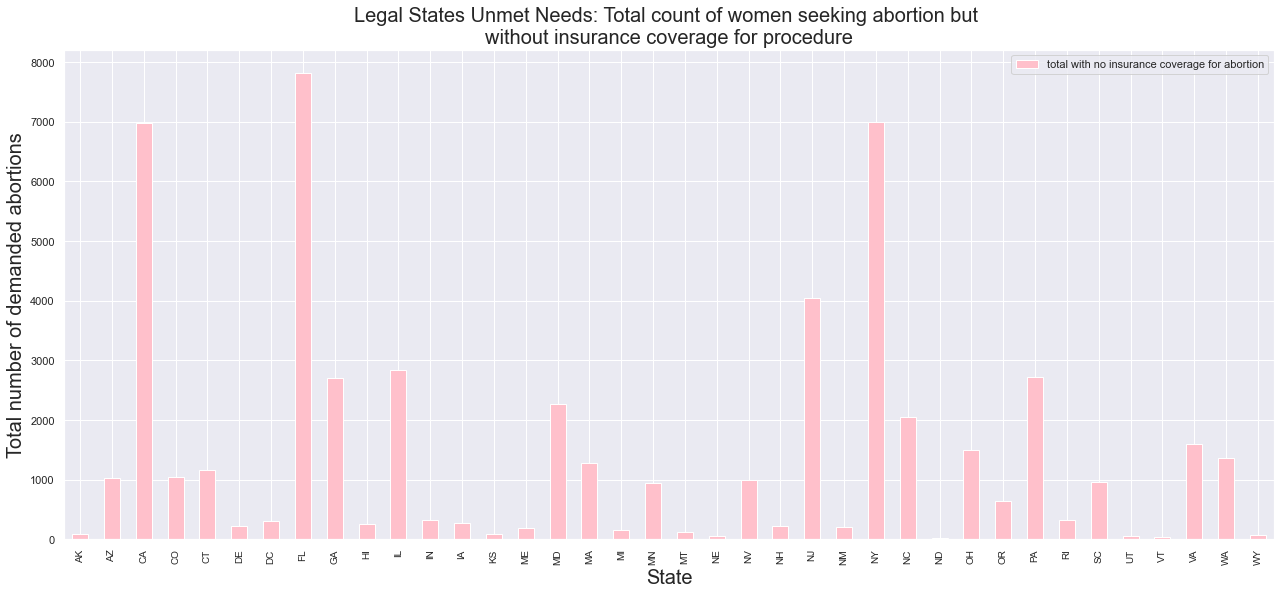

In [28]:
census.plot(x='state', y='total with no insurance coverage for abortion', kind='bar', color='pink')
plt.title('''Legal States Unmet Needs: Total count of women seeking abortion but 
without insurance coverage for procedure''', fontsize=20)
plt.subplots_adjust(top=5)
plt.xlabel('State', fontsize=20)
plt.subplots_adjust(left=0.1, right=1.5, bottom=0.05, top=0.9)
plt.tick_params(axis='x', labelsize=10)
plt.ylabel('Total number of demanded abortions', fontsize = 20)
plt.show()

In [29]:
sum_population = round(census['population'].sum())
sum_women_of_childbearing_age_seeking_abortion = \
    round(census['total population of women age 15-44 seeking abortion'].sum())
total_uninsured_abs = round(census['total uninsured'].sum())
total_public_not_covered_abs = round(census['total publicly insured, but with no coverage'].sum())
total_private_not_covered_abs = round(census['total privately insured, but with no coverage'].sum())
total_not_covered_abs = round(census['total with no insurance coverage for abortion'].sum())

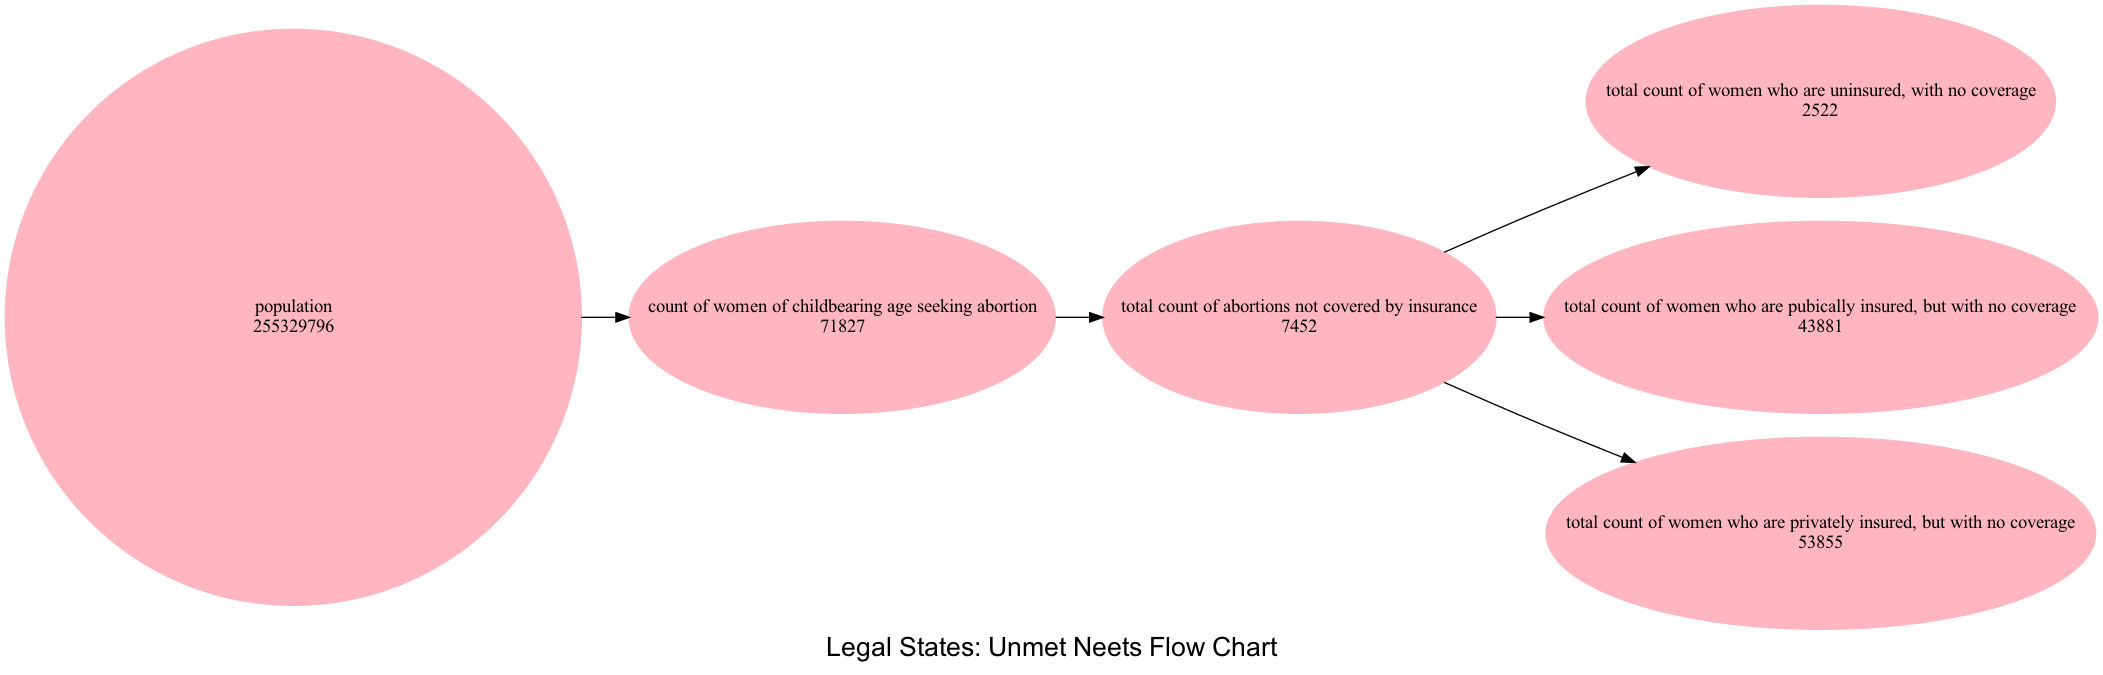

In [30]:
graphviz.set_jupyter_format('png')
dot = Digraph(comment='Flow Chart')
dot.graph_attr['label'] = 'Legal States: Unmet Neets Flow Chart'  
dot.node('population', 'Population')
dot.edge('population', 'count of women of childbearing age seeking abortion')
dot.edge('count of women of childbearing age seeking abortion', 'total count of abortions not covered by insurance')

data = {
    'population': sum_population,
    'count of women of childbearing age seeking abortion': sum_women_of_childbearing_age_seeking_abortion,
    'total count of abortions not covered by insurance': total_uninsured_abs,
    'total count of women who are uninsured, with no coverage': total_public_not_covered_abs,
    'total count of women who are pubically insured, but with no coverage': total_private_not_covered_abs,
    'total count of women who are privately insured, but with no coverage': total_not_covered_abs
}

min_value = min(data.values())
max_value = max(data.values())

for key in data:
    value = data[key]
    node_width = 2 + 4 * (value - min_value) / (max_value - min_value)
    node_height = 2 + 4 * (value - min_value) / (max_value - min_value)
    node_color = 'lightpink'
    node_label = '{}\n{}'.format(key, value)
    dot.node(key, node_label, style='filled', width=str(node_width), height=str(node_height), color=node_color)

    
dot.edge('total count of abortions not covered by insurance', 
         'total count of women who are uninsured, with no coverage')
dot.edge('total count of abortions not covered by insurance', 
         'total count of women who are privately insured, but with no coverage')
dot.edge('total count of abortions not covered by insurance', 
         'total count of women who are pubically insured, but with no coverage')

dot.attr(rankdir='LR', fontsize='20', fontname='Arial')
dot

While abortion might be legal in certain states, women might not be able to access the procedure given the high procedure cost and limits of insurance coverage. Therefore, in the unmet needs model for states where abortion is legal, gaps in insurance coverage are analyzed. Three insurance types are examined: women who are uninsured, privately insured, and publicly insured. For women who are privately or publicly insured, binary variables were created to analyze whether they live in a state that allows abortion insurance coverage. The “does public insurance not cover abortion?” variable was set to 1 for states whose count of publicly funded abortions was equal to 1, and set to 0 otherwise. The “does private insurance not cover abortion?” variable was numerically transformed from the “yes/no” column from our data on private insurance coverage by state. The “total population of women age 15-44 seeking abortion” variable was calculated in a similar way to the banned state model, using forecasted abortion rates for 2023.


<p> As shown in the bar chart of total counts, California, Florida, and New York appear to have the highest count of women seeking abortion but without insurance coverage. While these numbers are high, these numbers are not adjusted for the total population by state. To normalize the unmet need rate for each state, further analysis on the total unmet need divided by the total population in each state would help. Nonetheless, our results suggest these three states would benefit from additional funding towards abortion procedures, given the high unmet need counts.

<p> The flow chart for unmet needs shows the distribution of unmet needs by insurance type. A large portion of the total number of women seeking abortion but without insurance coverage comes from those who are privately insured yet without abortion coverage (534,830), followed by those uninsured then publicly insured. 



## Discussion and conclusions
In our unmet needs model, we are holding many assumptions regarding estimations in our data. As U.S. population data and percent ratios are pulled from the 2022 US Census, we are assuming this data carries over for 2023. Assumptions for our 2023 forecasted abortion rate are stated in our forecast model above. We are assuming that percent of women under Medicaid is comparable to the percent of women publicly insured, although there might be additional types of public funding available for abortion. Likewise, we are assuming that states that report zero publicly funded abortions do not allow public insurance coverage for abortions, although missing data or exceptions might be missing in this analysis. While our 'Total no. of publicly funded abortions’ comes from 2010, we are assuming those trends carry over to 2023 as well; however, given recent changes to abortion policy and contraception in the U.S., a more recent value for this count would strengthen our analysis. Lastly, we are assuming our forecasted abortion rate is comparable to the proportion of women who are seeking an abortion, although this rate does not necessarily factor in women who are seeking an abortion yet do not follow through with the procedure.

Overall, our analysis shows how states across the United States have varying restrictions and demands on abortions. Since the overturn of Roe v. Wade, recent state bans in abortions have restricted access for women residing in certain states. While there is variation on insurance coverage across states, many states do not allow insurance coverage for the procedure, creating financial constraints for women seeking an abortion.

<p> Banned states are particularly clustered in the south, although there are opportunities to travel to legal states. Funding abortion centers in neighboring states that are predicted to have a high demand - such as Florida, Georgia, New Mexico, Illinois, or Iowa - might help aid access for women seeking to travel out of state. According to the pie charts and unmet needs analysis, there is limited insurance coverage for abortions across all legal states, and is especially prominent in the majority of women who are privately insured. Given the high numbers of unmet needs for insurance coverage, funding the procedure itself might also improve abortion access for this demographic.

<p> Our calculations suggest that if pre-Dobbs and pre-Covid-19 trends continued, there would be a total of 12.6k women seeking abortion that live in banned states, whereas there is a total of 535k women who are seeking abortion that might not be able to access it due to lack of insurance coverage. While we have quantified the unmet need for different states in the U.S., these numbers are not an exact measure of the actual gaps in abortion access, and more analysis would need to be done to address funding opportunities. Given the nuances in willingness to pay for abortion, it is challenging for us to generalize how severe the lack of access due to financial constraints is. Likewise, additional analysis could be done on travel constraints to analyze the cost and feasibility of women living in banned states to travel out of state. To further analyze these gaps, we would need to gather additional data, such as on travel expenses and willingness to pay out of pocket for procedure. 

<p> There are additional analyses we could conduct to understand the gaps and demand for abortion across the United States. For instance, we could further stratify the unmet needs by age and compare differences in teenagers versus young adults. Given we are only looking at three insurance types (uninsured, private, public), we could gather more data on the different insurance types to understand particular gaps in coverage. Given the rise in contraceptive research and accessibility recently, we could also run analyses on contraceptive use in the United States, and how it plays a role in changes to abortion rates.